## CV Project - 7 

### Two class classification of heart sound signals using the discrete wavelet transform

###### Digesh Dansana (121CS0158)
###### Ashutosh Das (121CS0159)
###### Rajdeep Das (121CS0160)
###### Sourav Das (121CS0161)


In [1]:
import os
import pywt
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense, Conv1D,MaxPool1D,Flatten,BatchNormalization

### Sample output for a Normal Test Case 

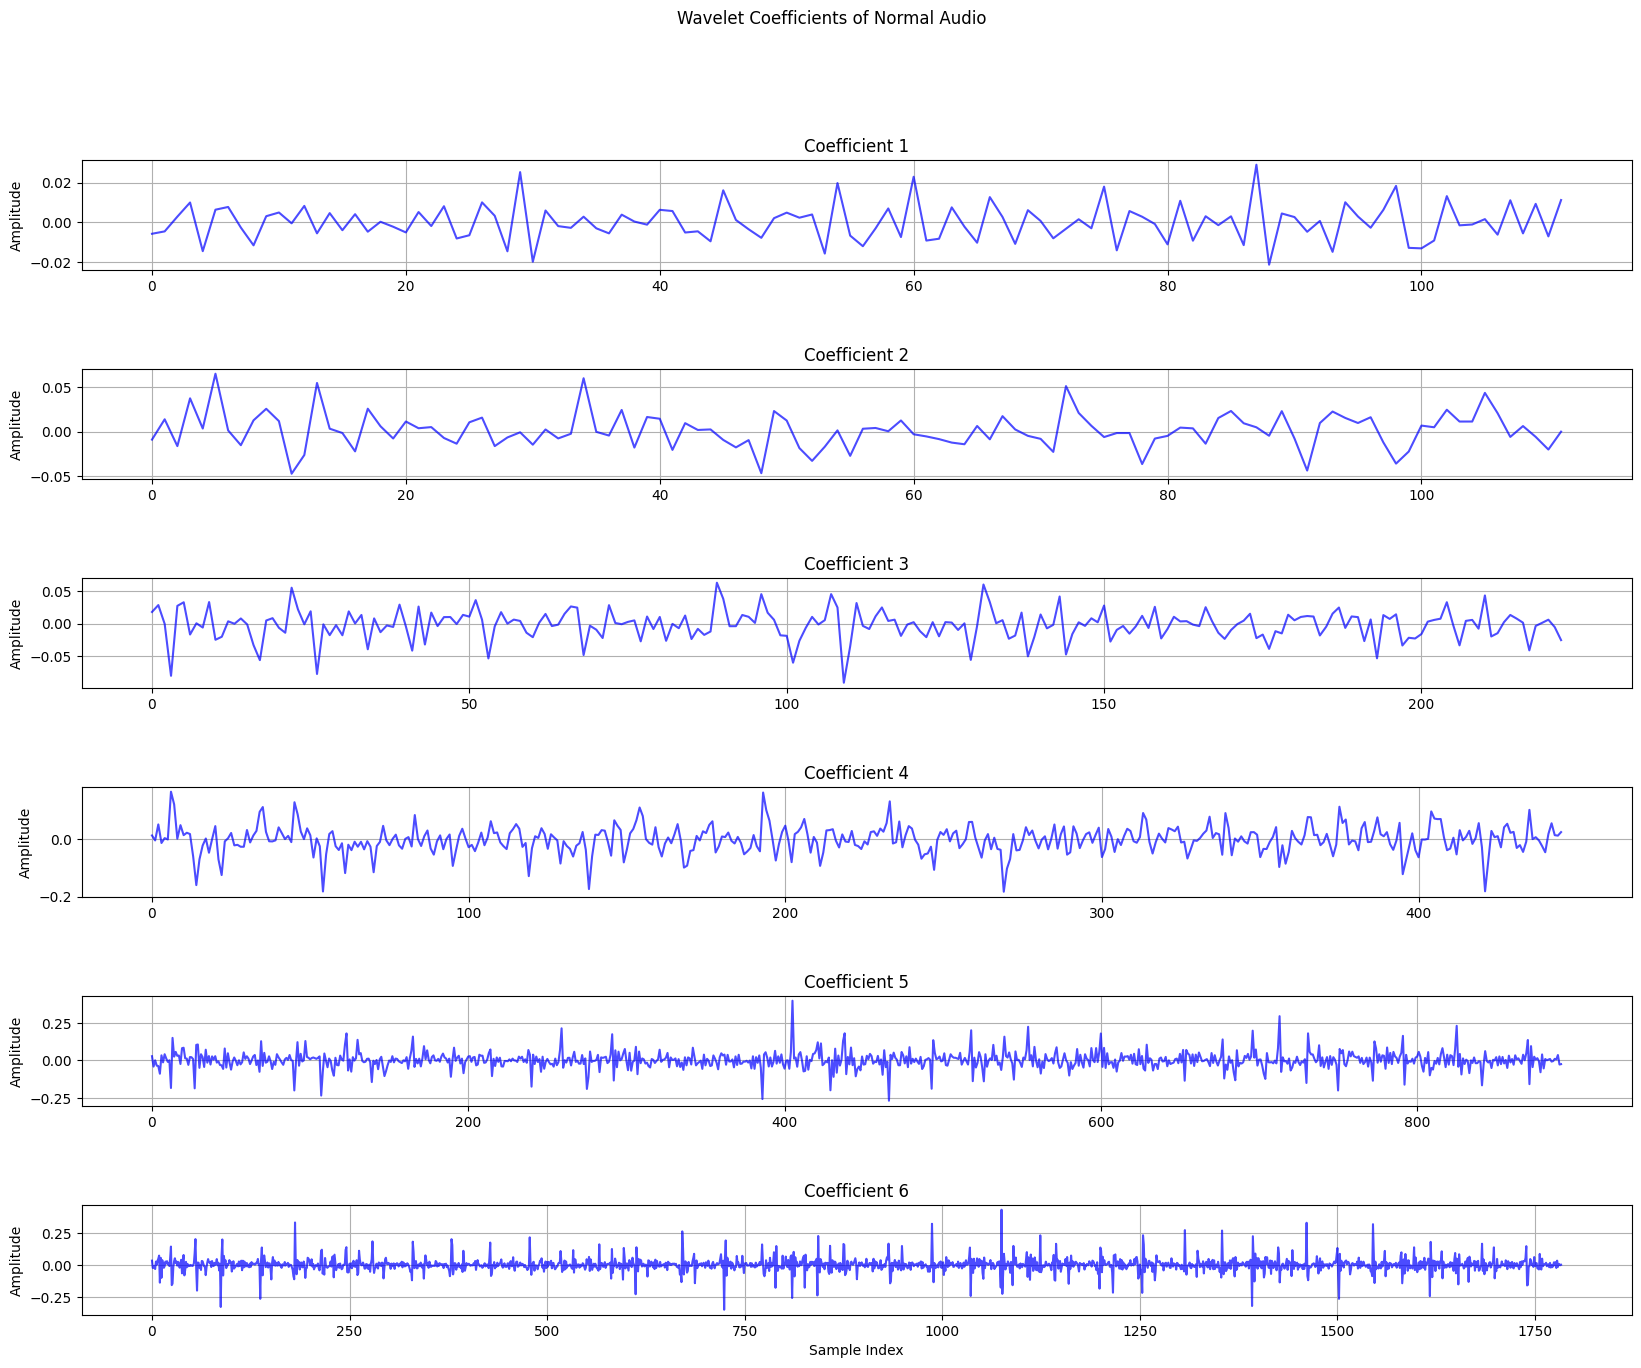

In [2]:
# Example of how to use wavelet transform on a single audio file
from matplotlib import transforms


filename = os.getcwd() + '/data/Normal/a0007.wav'

# Load audio file
data, sr = librosa.load(filename)

# Resample audio data to new sample rate
new_sample_rate = 100
resampled_data = librosa.resample(y=data, orig_sr=sr, target_sr=new_sample_rate)

# Perform wavelet transform
wavelet_coeffs = pywt.wavedec(resampled_data, 'haar', level=5)
cA1, cD5, cD4, cD3, cD2, cD1 = wavelet_coeffs

# Plot wavelet coefficients
plt.figure(figsize=(20, 15))  # Increase the plot window size
for i, coeff in enumerate(wavelet_coeffs):
    plt.subplot(6, 1, i+1)
    plt.plot(coeff, color='b', alpha=0.7)
    plt.ylabel('Amplitude')
    plt.title(f'Coefficient {i+1}')
    plt.grid(True)

plt.subplots_adjust(hspace=0.9)  # Increase the vertical space between subplots
plt.suptitle('Wavelet Coefficients of Normal Audio')  # Add a title to the entire plot
plt.xlabel('Sample Index')
plt.show()



### Sample output for a Abnormal Test Case 

<Figure size 640x480 with 0 Axes>

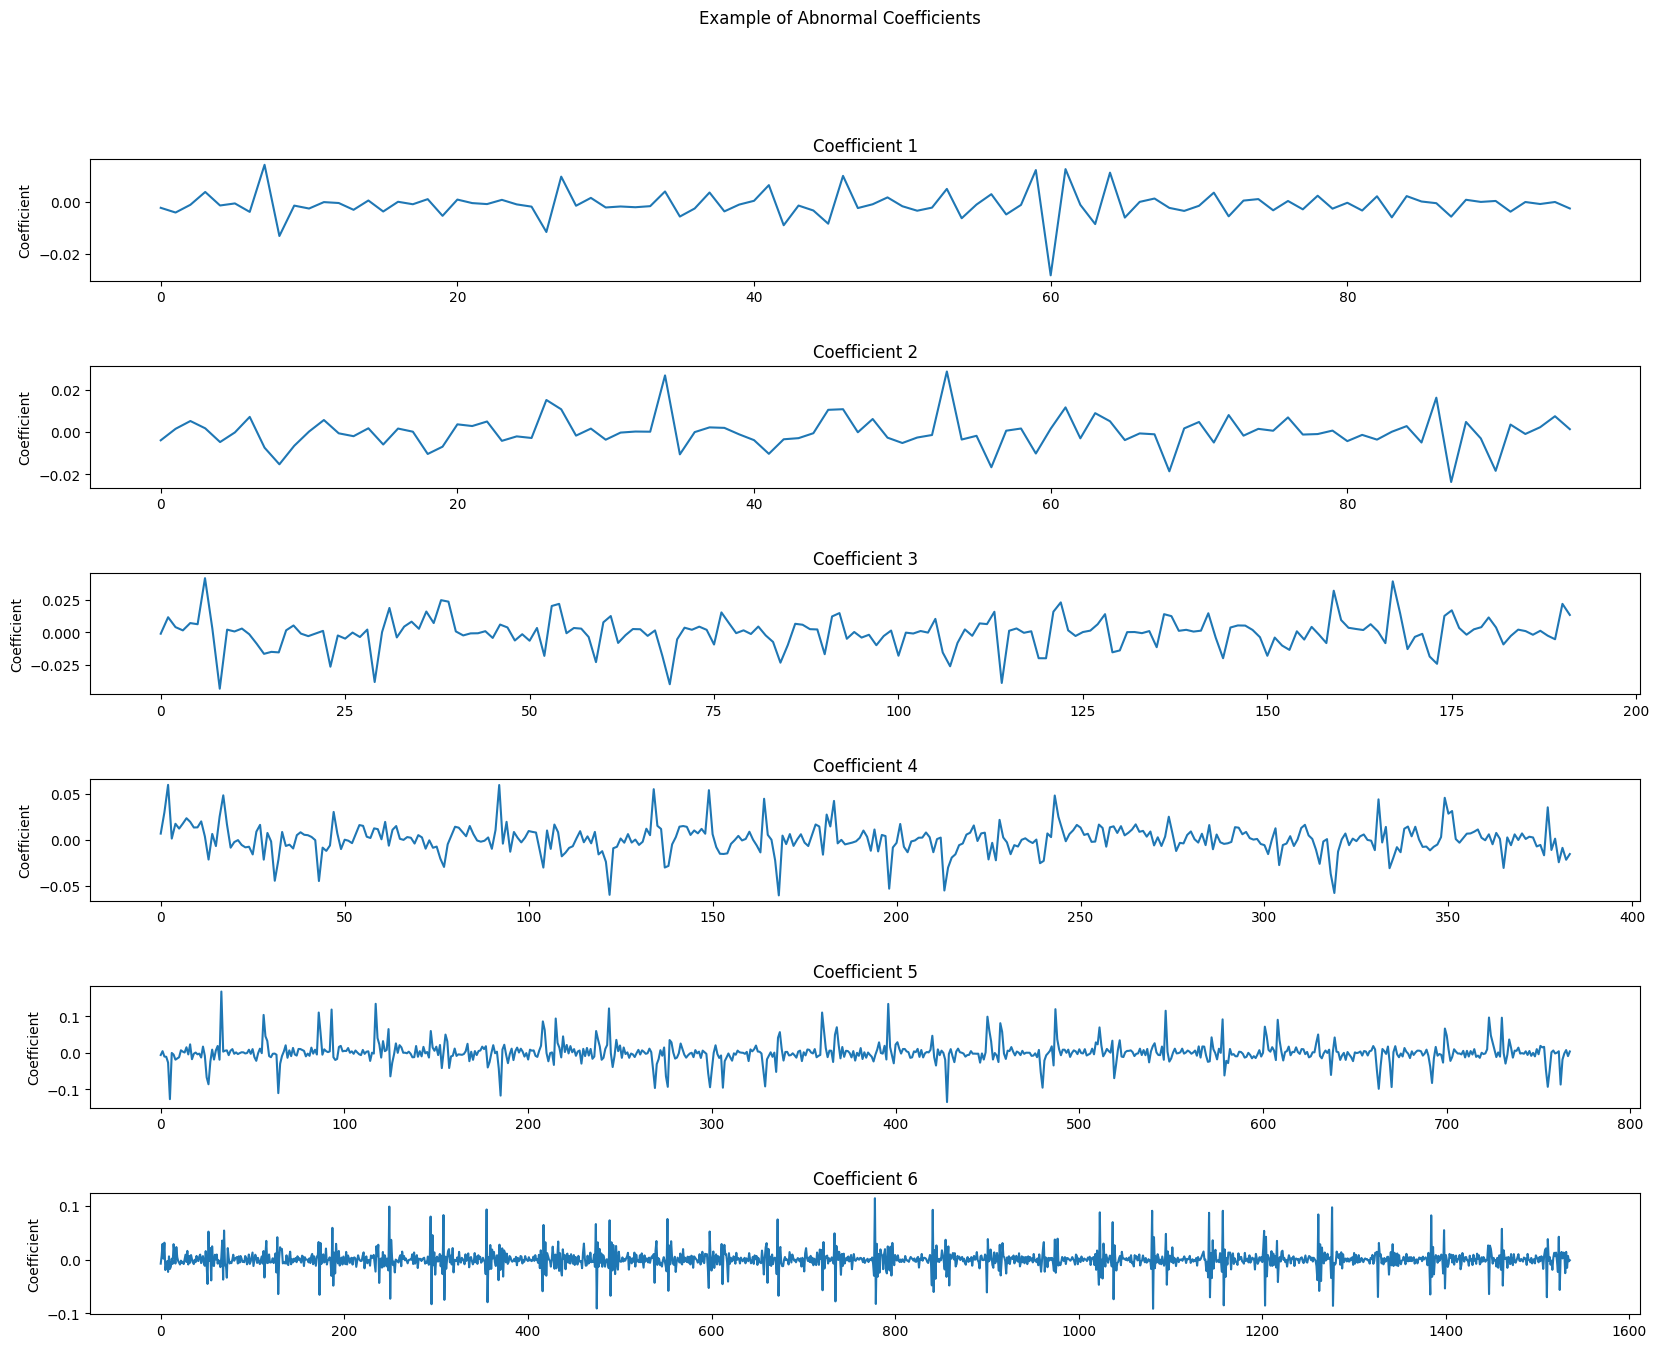

In [3]:
#Example of how to use wavelet transform on a single audio file
filename = os.getcwd() + '/data/Abnormal/a0003.wav'
data , sr = librosa.load(filename)


new_sample_rate = 100
resampled_data = librosa.resample(y=data,orig_sr=sr,target_sr=new_sample_rate)

wavelet_coeffs = pywt.wavedec(resampled_data, 'haar', level=5)
cA1, cD5, cD4, cD3, cD2, cD1 = wavelet_coeffs

# plot
plt.figure()
wavelet_coeffs = [cA1, cD5, cD4, cD3, cD2, cD1]

plt.figure(figsize=(20, 15))  # Increase the plot window size
for i, coeff in enumerate(wavelet_coeffs):
    plt.subplot(6, 1, i+1)
    plt.plot(coeff)
    plt.ylabel('Coefficient')
    plt.title(f'Coefficient {i+1}')

plt.subplots_adjust(hspace=0.7)  # Increase the vertical space between subplots
plt.suptitle('Example of Abnormal Coefficients')  # Add a title to the entire plot
plt.show()


### Extraction of Audio files along with labels and spilt them into training and testing set

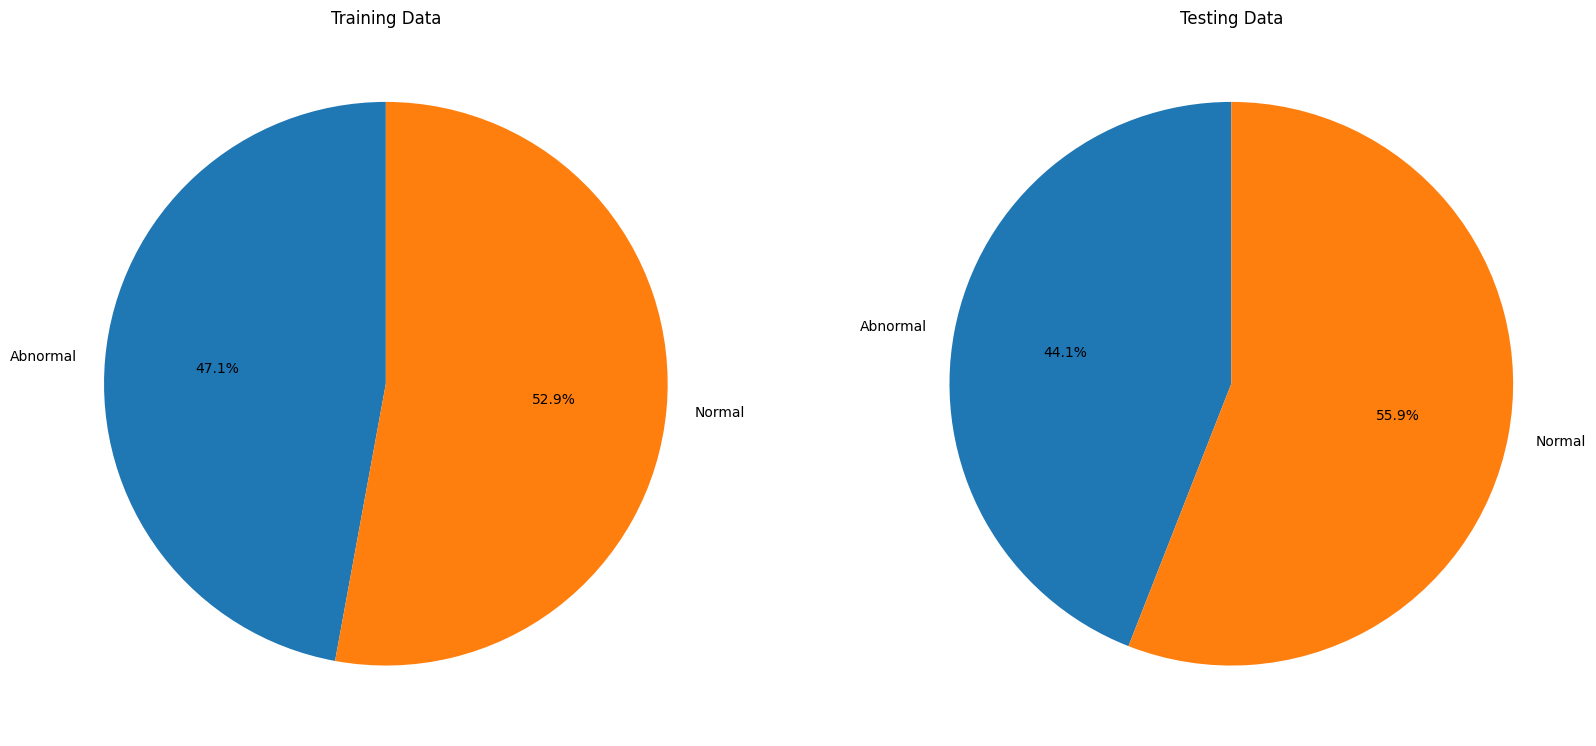

In [4]:

root_dir = os.getcwd() + '/data'

# Lists to store audio files and their corresponding labels
AudioFiles = []
AudioLabels = []

# Iterate through directories and files
for subdir, dirs, files in os.walk(root_dir, topdown=False):
    for file in files:
        # Check if file is a .wav file
        if file.endswith('.wav'):
            AudioFiles.append(os.path.join(subdir, file))
            if "Abnormal" in subdir:
                AudioLabels.append(0)  # Abnormal label
            elif "Normal" in subdir:
                AudioLabels.append(1)  # Normal label
        else:
            # Skip non-.wav files
            print(f"Skipping fi 2016le: {file}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(AudioFiles, AudioLabels, test_size=0.2)

# Pie chart to visualize the distribution of labels
labels = 'Abnormal', 'Normal'
sizes_train = [y_train.count(0), y_train.count(1)]
sizes_test = [y_test.count(0), y_test.count(1)]

fig, axes = plt.subplots(1, 2, figsize=(20, 15))
axes[0].pie(sizes_train, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Training Data')
axes[1].pie(sizes_test, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Testing Data')
plt.show()




### Function to resample the audio files and calculate the discrete wavelet tranform for these files

In [5]:
#write a function to calculate the discrete wavelet transform of the audio files
def wavelet_transform(data):
    wavelet = 'haar'
    level = 5
    d, sr = librosa.load(data)
    new_sample_rate = 1000
    resampled_data = librosa.resample(y=d,orig_sr=sr,target_sr=new_sample_rate)
    wavelet_coeffs = pywt.wavedec(resampled_data, wavelet, level=level)
    wavelet_coeffs = np.concatenate(wavelet_coeffs)

    #returning the first 1000 coefficients
    return wavelet_coeffs[:1000]
    

### Feature Extraction process

In [6]:
train_features = []
test_features = []

for file in X_train:
    #data, sr = librosa.load(file)
    wavelet_coeffs = wavelet_transform(file)
    train_features.append(wavelet_coeffs)

for file in X_test:
    #data, sr = librosa.load(file)
    wavelet_coeffs = wavelet_transform(file)
    test_features.append(wavelet_coeffs)



# # Find the maximum length of the wavelet coefficients
max_length = max([len(feature) for feature in train_features + test_features])

train_features = [np.pad(feature, (0, max_length - len(feature))) for feature in train_features]
test_features = [np.pad(feature, (0, max_length - len(feature))) for feature in test_features]

train_features = np.array(train_features)
test_features = np.array(test_features)

print(train_features.shape)
print(test_features.shape)


# Convert the lists of labels into NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)





(1144, 1000)
(286, 1000)


#### accuracies of all the models are saved for further comparison

In [7]:
all_model_accuracy = []

### CNN model

In [8]:
def create_model(row,col):

        model = Sequential()

        model.add(Conv1D(256, 3, activation='relu', input_shape=(row,col)))
        model.add(MaxPool1D(2))
        # model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv1D(128, 3, activation='relu'))
        model.add(MaxPool1D(2))
        # model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv1D(64, 3, activation='relu'))
        model.add(MaxPool1D(2))
        # model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Flatten())

        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))


        return model

### Model creation for further evalutation

In [9]:
# Base model creation and summary
model = create_model(train_features.shape[1], 1)

In [10]:
extracted_features = keras.Model(inputs=model.inputs, outputs=model.layers[0].output)


# Extract features from training data
train_features = extracted_features.predict(train_features)
train_features = train_features[:, :10000]


# Extract features from testing data
test_features = extracted_features.predict(test_features)
test_features = test_features[:, :10000]
# test_features = test_features.reshape(test_features.shape[0], -1)


print(train_features.shape)
print(test_features.shape)


9/9 [==============================] - 0s 19ms/step
(1144, 998, 256)
(286, 998, 256)


In [11]:
train_f = train_features.reshape(train_features.shape[0],-1)
test_f = test_features.reshape(test_features.shape[0],-1)

In [12]:
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(train_f, y_train)
y_pred = rf.predict(test_f)
accuracy = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy}')
all_model_accuracy.append(accuracy)


Random Forest Accuracy: 0.7377622377622378


In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Use a simpler base estimator
simple_base_estimator = DecisionTreeClassifier(max_depth=1)


# Train an AdaBoost classifier
abc = AdaBoostClassifier(base_estimator=simple_base_estimator, n_estimators=50)
abc.fit(train_f, y_train)
y_pred_1 = abc.predict(test_f)
accuracy = accuracy_score(y_test, y_pred_1)
print(f'AdaBoost Accuracy: {accuracy}')
all_model_accuracy.append(accuracy)

AdaBoost Accuracy: 0.7097902097902098


In [15]:
model_accuracies = []

def create_cnn_model(row,col):

        model = Sequential()

        model.add(Conv1D(256, 3, activation='relu', input_shape=(row,col)))
        model.add(MaxPool1D(2))
        # model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv1D(128, 3, activation='relu'))
        model.add(MaxPool1D(2))
        # model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Conv1D(64, 3, activation='relu'))
        model.add(MaxPool1D(2))
        # model.add(BatchNormalization())
        model.add(Dropout(0.4))

        model.add(Flatten())

        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=Adam(learning_rate= 0.01), loss='binary_crossentropy', metrics=['accuracy'])
        
        return model

model_1=create_cnn_model(train_features.shape[1], 256)
model_1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 996, 256)          196864    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 498, 256)          0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 498, 256)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 496, 128)          98432     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 248, 128)          0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 248, 128)         

In [16]:
for i in range(3):
    model_1.fit(train_features, y_train, epochs=5, batch_size=32, validation_data=(test_features, y_test), verbose=1)
    scores = model_1.evaluate(test_features, y_test, verbose=1)
    model_accuracies.append(np.mean(scores))

print(np.mean(model_accuracies))
all_model_accuracy.append(np.mean(model_accuracies))

Epoch 1/5


36/36 [==============================] - 20s 406ms/step - loss: 0.7355 - accuracy: 0.6084 - val_loss: 0.6114 - val_accuracy: 0.7343
Epoch 2/5
36/36 [==============================] - 11s 313ms/step - loss: 0.6150 - accuracy: 0.7107 - val_loss: 0.6077 - val_accuracy: 0.7133
Epoch 3/5
36/36 [==============================] - 11s 308ms/step - loss: 0.5621 - accuracy: 0.7456 - val_loss: 0.5439 - val_accuracy: 0.7483
Epoch 4/5
36/36 [==============================] - 11s 296ms/step - loss: 0.5445 - accuracy: 0.7421 - val_loss: 0.5984 - val_accuracy: 0.7238
Epoch 5/5
9/9 [==============================] - 1s 74ms/step - loss: 0.6124 - accuracy: 0.7098
Epoch 1/5
36/36 [==============================] - 18s 452ms/step - loss: 0.5304 - accuracy: 0.7544 - val_loss: 0.5996 - val_accuracy: 0.7203
Epoch 2/5
36/36 [==============================] - 11s 314ms/step - loss: 0.5761 - accuracy: 0.6844 - val_loss: 0.6659 - val_accuracy: 0.4510
Epoch 3/5
36/36 [==============================] -

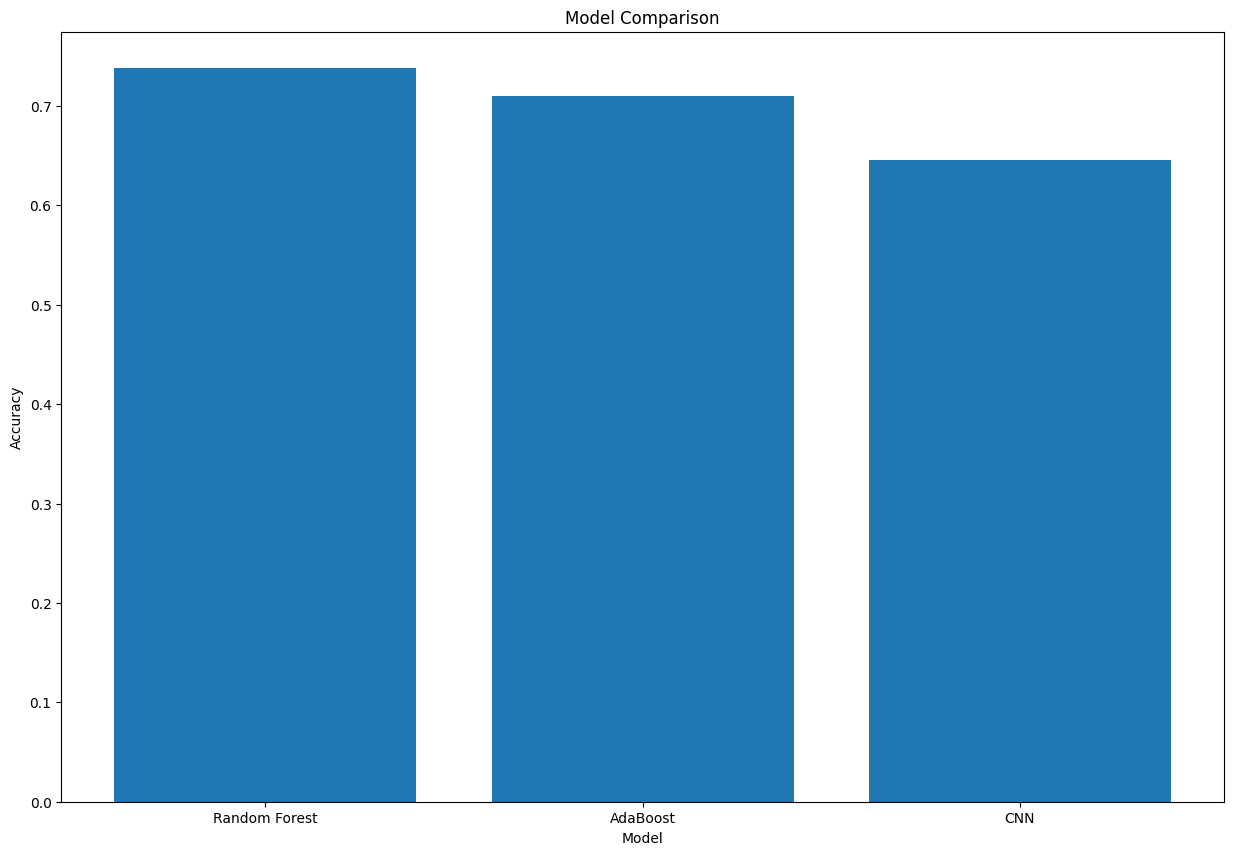

In [17]:
# Plot the accuracy of all models
plt.figure(figsize=(15, 10))  # Increase the plot window size
cases = ['Random Forest', 'AdaBoost' , 'CNN', ]
plt.bar(cases, all_model_accuracy)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()